<a href="https://colab.research.google.com/github/lisabortiz/Data-Science-Portfolio/blob/main/Project_4/Spotify_Description_for_Students_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


## Problem Definition
>"What's going on?"

This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.



The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The hyperparameters of the trees should be carefully selected to avoid over-fitting.


There are three main challenges for this project:

1. Determining the outcome ( i.e. target ).  There is a "popularity" column.  But other columns may or may not be more appropriate indicators of popularity.

1. Choosing appropriate predictors ( i.e. features ). When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song. It might help to imagine that the song will not be released for several weeks.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.



Once again, be sure to go through the whole data science process and document as such in your Jupyter notebook.

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .



## Data Collection/Sources
>"Initial Setup"

In [ ]:
# import os
# import magic
# import random
# import duckdb
import pandas as pd
from pathlib import Path
import sqlite3 as db
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sklearn
import numpy as np
from sklearn import datasets, metrics, model_selection
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

### Load the data

In [ ]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: XF1S3TqPTD7AAscrU9PWs9cytIoYYj/nk8bY30gDaIAVY19PnWh9zrJq42zdZM9fmgHLPfDVYwcLUPZkIcIHG4NQGOxl+kfT
x-amz-request-id: W1BXFD92K5X3G43N
Date: Mon, 03 Nov 2025 18:02:37 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Content-Length: 738124
Server: AmazonS3



In [ ]:
!curl -s -O {url}

In [ ]:
ls -la

total 740
drwxr-xr-x 1 root root   4096 Nov  3 18:02 ./
drwxr-xr-x 1 root root   4096 Nov  3 18:01 ../
drwxr-xr-x 4 root root   4096 Oct 31 17:50 .config/
drwxr-xr-x 1 root root   4096 Oct 31 17:50 sample_data/
-rw-r--r-- 1 root root 738124 Nov  3 18:02 Spotify.csv


In [ ]:
!ls

sample_data  Spotify.csv


In [ ]:
!head -1 Spotify.csv | tr , '\n' | cat -n

     1	Index
     2	Highest Charting Position
     3	Number of Times Charted
     4	Week of Highest Charting
     5	Song Name
     6	Streams
     7	Artist
     8	Artist Followers
     9	Song ID
    10	Genre
    11	Release Date
    12	Weeks Charted
    13	Popularity
    14	Danceability
    15	Energy
    16	Loudness
    17	Speechiness
    18	Acousticness
    19	Liveness
    20	Tempo
    21	Duration (ms)
    22	Valence
    23	Chord


In [ ]:
#load data from CSV File
spotify_orig = pd.read_csv("Spotify.csv")
spotify_orig

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,"4,630,675",Dua Lipa,27167675,2ekn2ttSfGqwhhate0LSR0,"['dance pop', 'pop', 'uk pop']",...,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,"4,623,030",Jorge & Mateus,15019109,2PWjKmjyTZeDpmOUa3a5da,"['sertanejo', 'sertanejo universitario']",...,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),"4,620,876",Camila Cabello,22698747,1rfofaqEpACxVEHIZBJe6W,"['dance pop', 'electropop', 'pop', 'post-teen ...",...,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,"4,607,385","Dadá Boladão, Tati Zaqui, OIK",208630,5F8ffc8KWKNawllr5WsW0r,"['brega funk', 'funk carioca']",...,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F


In [ ]:
spotify_orig.isnull().sum().sum()

np.int64(0)

In [ ]:
spotify_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

### Create a copy

In [ ]:
spotify = spotify_orig.copy()

###Inspection
Now that the libraries are imported and the data set is loaded, we can verify it's import and perform an initial inspection of the data.

In the inital check, we look at a few details:


*   Head (first 5 rows)
*   Tail (Last 5 rows)
*   Info (File size, data types, rows, colums)
*   Shape (Row and Column Count)
*   Size (individual elements)

This gives a quick glance at what kind of forseeable challenges with the current data set.


In [ ]:
spotify.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [ ]:
spotify.tail()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,"4,630,675",Dua Lipa,27167675,2ekn2ttSfGqwhhate0LSR0,"['dance pop', 'pop', 'uk pop']",...,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,"4,623,030",Jorge & Mateus,15019109,2PWjKmjyTZeDpmOUa3a5da,"['sertanejo', 'sertanejo universitario']",...,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),"4,620,876",Camila Cabello,22698747,1rfofaqEpACxVEHIZBJe6W,"['dance pop', 'electropop', 'pop', 'post-teen ...",...,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,"4,607,385","Dadá Boladão, Tati Zaqui, OIK",208630,5F8ffc8KWKNawllr5WsW0r,"['brega funk', 'funk carioca']",...,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F
1555,1556,199,1,2019-12-27--2020-01-03,Lover (Remix) [feat. Shawn Mendes],"4,595,450",Taylor Swift,42227614,3i9UVldZOE0aD0JnyfAZZ0,"['pop', 'post-teen pop']",...,0.448,0.603,-7.176,0.064,0.433,0.0862,205.272,221307,0.422,G


In [ ]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [ ]:
spotify.shape


(1556, 23)

In [ ]:
spotify.size

35788

In [ ]:
spotify.isnull().sum().sum()

np.int64(0)

In [ ]:
spotify['Genre'].head(50)

,Genre
0,"['indie rock italiano', 'italian pop']"
1,['australian hip hop']
2,['pop']
3,"['pop', 'uk pop']"
4,"['lgbtq+ hip hop', 'pop rap']"
5,"['lgbtq+ hip hop', 'pop rap']"
6,"['dance pop', 'pop']"
7,"['puerto rican pop', 'trap latino']"
8,"['latin', 'reggaeton', 'trap latino']"
9,"['indie rock italiano', 'italian pop']"


### Check Data For Use

Some of the important details to check regarding data set are the following:


*   Total Number of Null Values
*   Total Number of Unique Values
*   Target and its contents
*   Null Values in Target Column
*   Percentage of Null Values compared to the Whole Column
*   Sums

This gives some insight to the direction we should take to start cleaning data.  

There is a significant amount of null values in Target, Columns and Rows.  


In [ ]:
spotify.isnull().sum().sum()

np.int64(0)

In [ ]:
spotify.describe(include ="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Index,1556.0,NaN,NaN,NaN,778.5,449.322824,1.0,389.75,778.5,1167.25,1556.0
Highest Charting Position,1556.0,NaN,NaN,NaN,87.744216,58.147225,1.0,37.0,80.0,137.0,200.0
Number of Times Charted,1556.0,NaN,NaN,NaN,10.66838,16.360546,1.0,1.0,4.0,12.0,142.0
Week of Highest Charting,1556,83,2019-12-27--2020-01-03,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song Name,1556,1556,Lover (Remix) [feat. Shawn Mendes],1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Streams,1556,1556,"4,595,450",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist,1556,716,Taylor Swift,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist Followers,1556,600,42227614,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song ID,1556,1517,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,1556,395,[],75,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
target = 'Popularity'

In [ ]:
spotify[target].describe(include ="all").transpose()

,Popularity
count,1556
unique,70
top,75
freq,67


In [ ]:
spotify.sort_values(by=target, axis=0)['Popularity']


,Popularity
784,
636,
654,
1140,
1538,
...,...
4,96
5,97
3,98
2,99


In [ ]:
spotify[target].isnull().sum()

np.int64(0)

In [ ]:
spotify.duplicated().sum()

np.int64(0)

## Data Cleaning

>  "Clean Up Data"


In [ ]:
#There were several rows that had values of blank spaces.  This is converting into NaN
spotify = spotify.replace(' ', np.nan)

In [ ]:
spotify.isnull().sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,11
Song ID,11
Genre,11


In [ ]:
#Remove any row with nulls.  There were 11 found.
spotify.dropna(axis=0, how='any', inplace=True)
spotify.isnull().sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,0
Song ID,0
Genre,0


In [ ]:
#Streams column has commas in data value, and this removes the commas in place.
spotify['Streams'] = spotify['Streams'].astype(str).str.replace(',', '', regex=False)

In [ ]:
spotify.columns

Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence',
       'Chord'],
      dtype='object')

In [ ]:
# Select the columns we identified as "Unique Identifiers" and Columns too similar to our target in our inspection by assigning
# it to a list, ("bye"), that we want to remove.
bye = ['Index', 'Highest Charting Position', 'Release Date', 'Week of Highest Charting', 'Weeks Charted', 'Artist', 'Song Name', 'Song ID', 'Genre', 'Chord']

In [ ]:
spot_drop = spotify[bye].copy()

In [ ]:
spot_drop.shape

(1545, 10)

In [ ]:
spotify.drop(columns=bye, inplace=True)

In [ ]:
#The columns are still object type.  This is trying to convert into numbers.
cols_to_convert = spotify.columns

In [ ]:
cols_to_convert.drop(target)

Index(['Number of Times Charted', 'Streams', 'Artist Followers',
       'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
       'Liveness', 'Tempo', 'Duration (ms)', 'Valence'],
      dtype='object')

In [ ]:
for col in cols_to_convert:
    spotify[col] = pd.to_numeric(spotify[col], errors='coerce')

In [ ]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number of Times Charted  1545 non-null   int64  
 1   Streams                  1545 non-null   int64  
 2   Artist Followers         1545 non-null   int64  
 3   Popularity               1545 non-null   int64  
 4   Danceability             1545 non-null   float64
 5   Energy                   1545 non-null   float64
 6   Loudness                 1545 non-null   float64
 7   Speechiness              1545 non-null   float64
 8   Acousticness             1545 non-null   float64
 9   Liveness                 1545 non-null   float64
 10  Tempo                    1545 non-null   float64
 11  Duration (ms)            1545 non-null   int64  
 12  Valence                  1545 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 169.0 KB


## Exploratory Data Analysis
> "Look Around"

In [ ]:
spotify[spotify['Popularity'] == 0].head()

,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence
65,83,8821971,1250353,0,0.793,0.793,-4.521,0.0830,0.01230,0.0951,123.950,183290,0.679
83,3,7465445,1250353,0,0.659,0.667,-4.668,0.0339,0.00173,0.1000,115.982,258004,0.468
118,21,6300416,1250353,0,0.658,0.634,-5.797,0.0413,0.01060,0.1320,139.980,170813,0.290
156,6,5576844,1250353,0,0.808,0.660,-6.237,0.0395,0.03580,0.1380,107.994,235556,0.804
164,83,5436286,1250353,0,0.701,0.425,-10.965,0.3750,0.32800,0.1000,135.128,194088,0.562


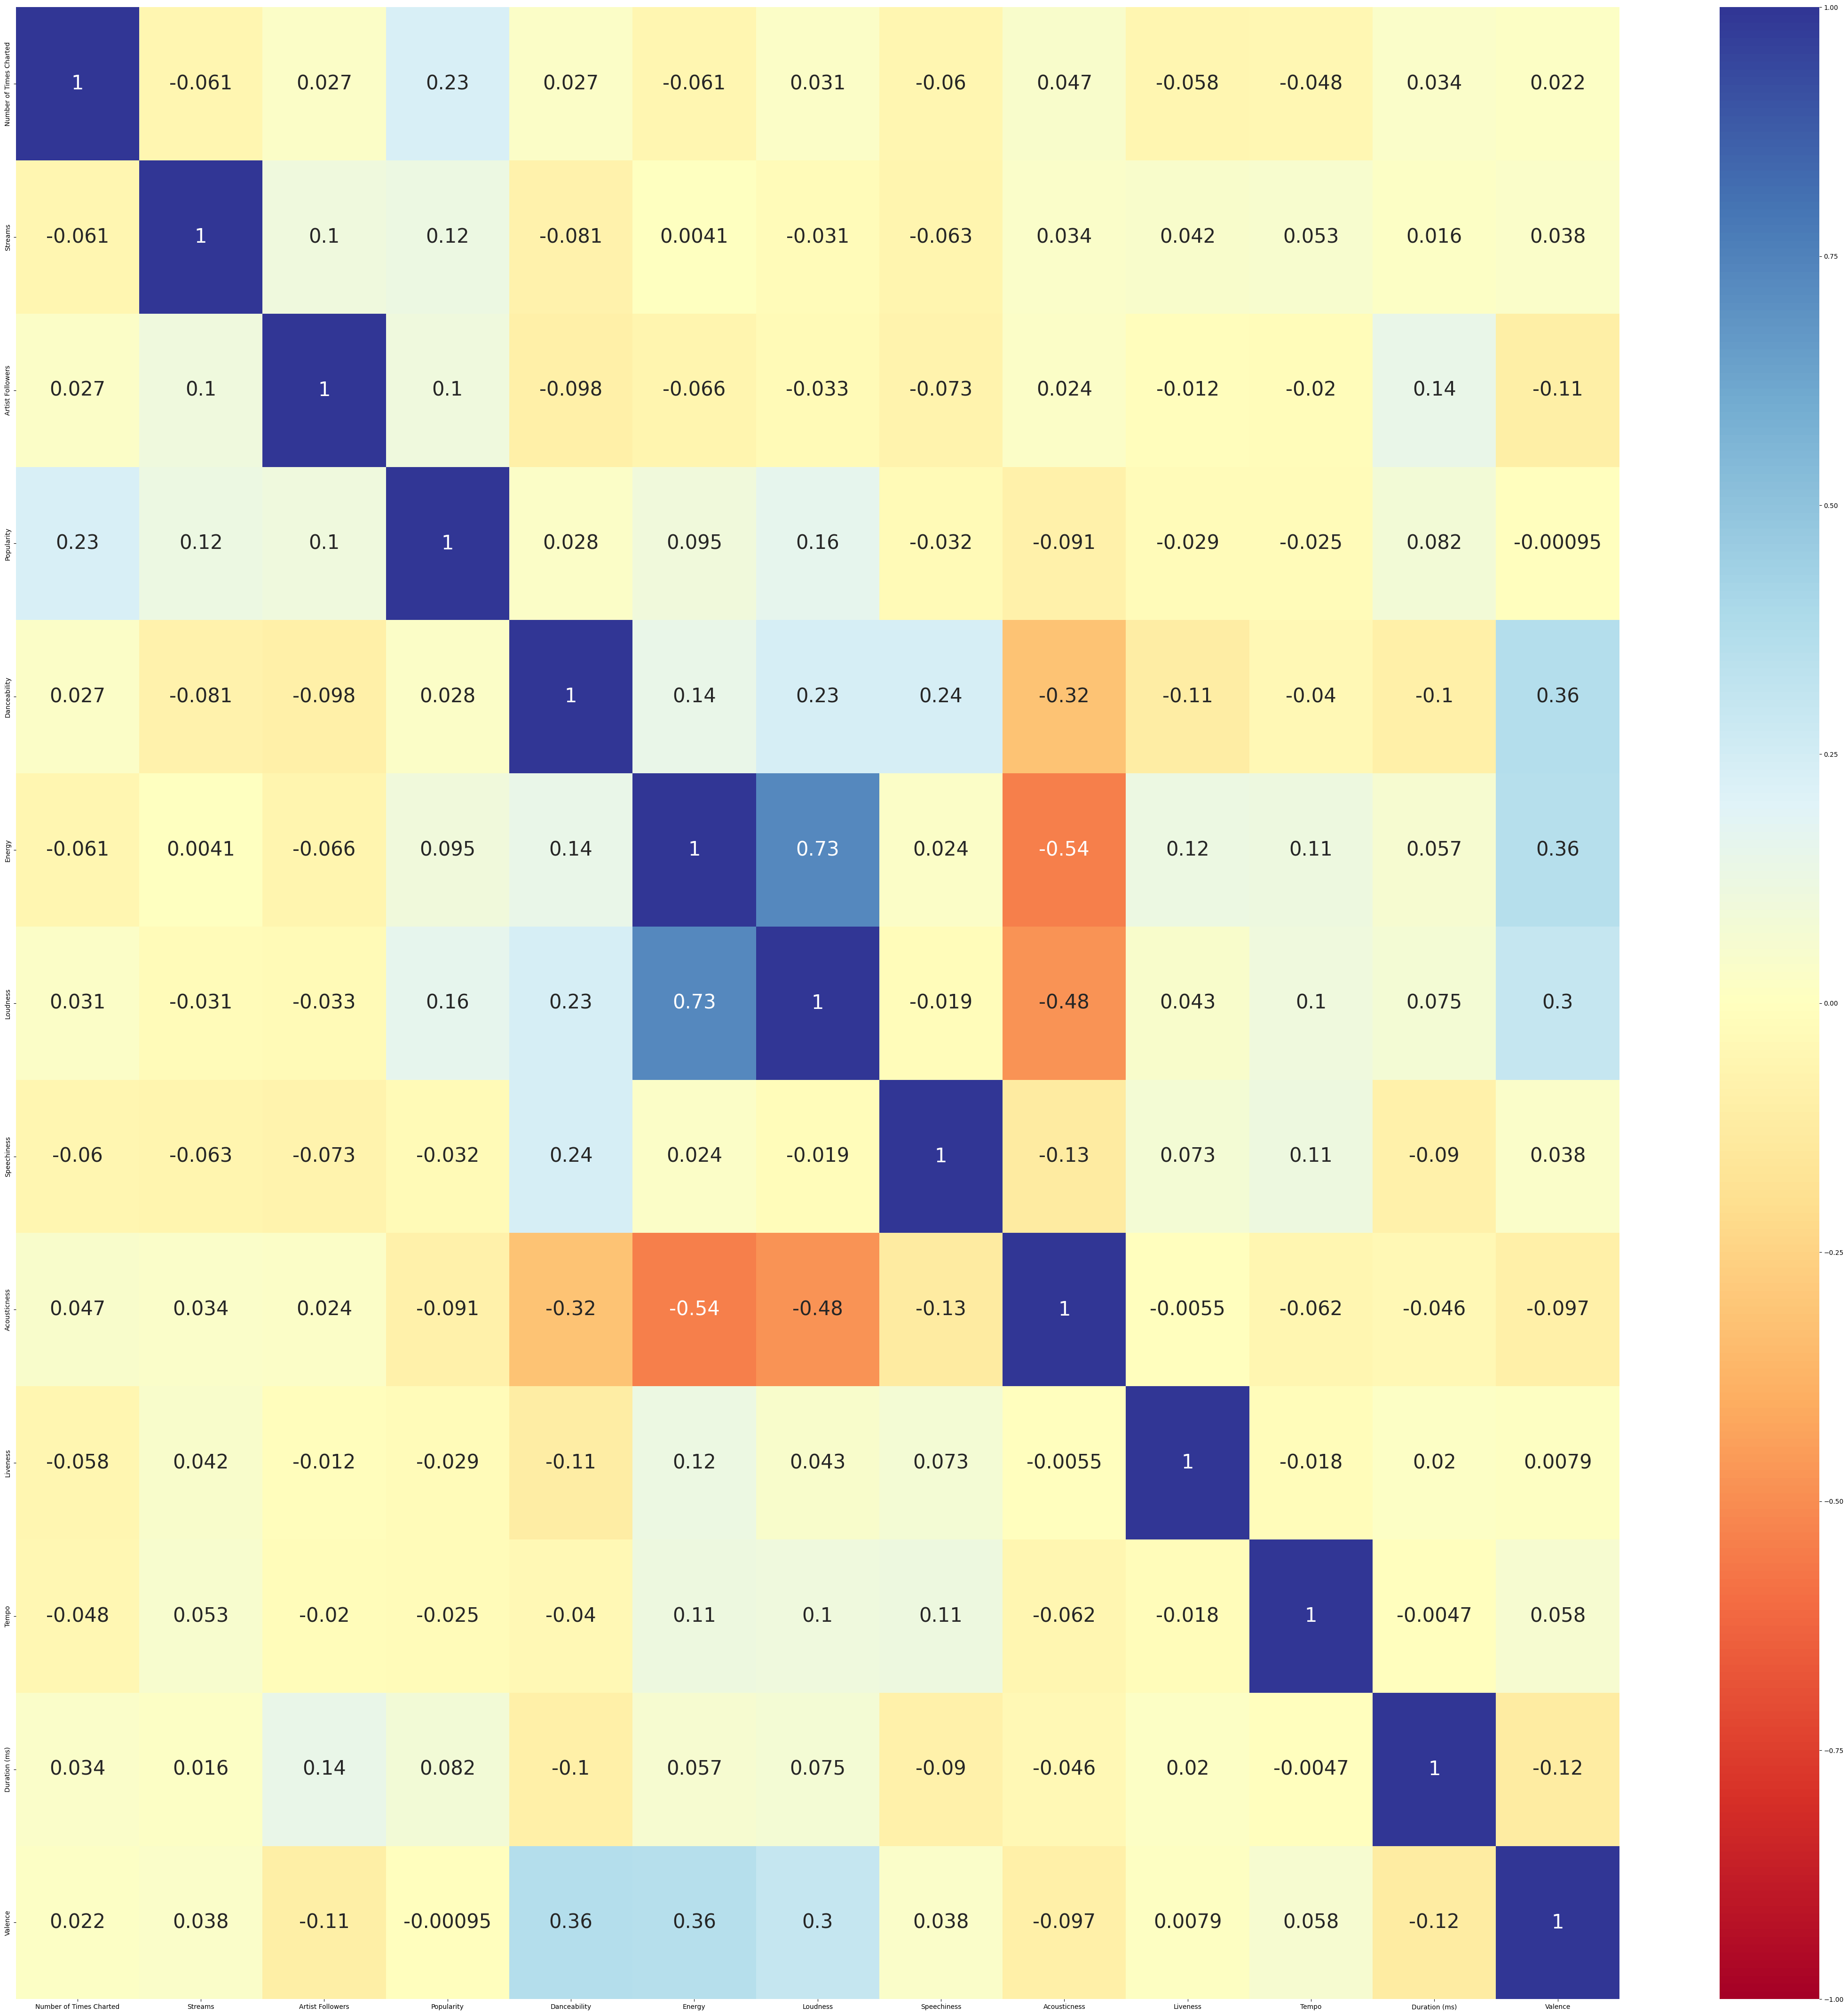

In [ ]:
#Correlation plot shows relationship between "target" and other variables.

corr = spotify.select_dtypes(include='number').corr()
plt.figure(figsize=(55,55))
sns.heatmap(corr, cmap='RdYlBu', annot=True, vmin = -1, vmax = 1, annot_kws={"fontsize": 30});

array([[<Axes: title={'center': 'Number of Times Charted'}>,
        <Axes: title={'center': 'Streams'}>,
        <Axes: title={'center': 'Artist Followers'}>,
        <Axes: title={'center': 'Popularity'}>],
       [<Axes: title={'center': 'Danceability'}>,
        <Axes: title={'center': 'Energy'}>,
        <Axes: title={'center': 'Loudness'}>,
        <Axes: title={'center': 'Speechiness'}>],
       [<Axes: title={'center': 'Acousticness'}>,
        <Axes: title={'center': 'Liveness'}>,
        <Axes: title={'center': 'Tempo'}>,
        <Axes: title={'center': 'Duration (ms)'}>],
       [<Axes: title={'center': 'Valence'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

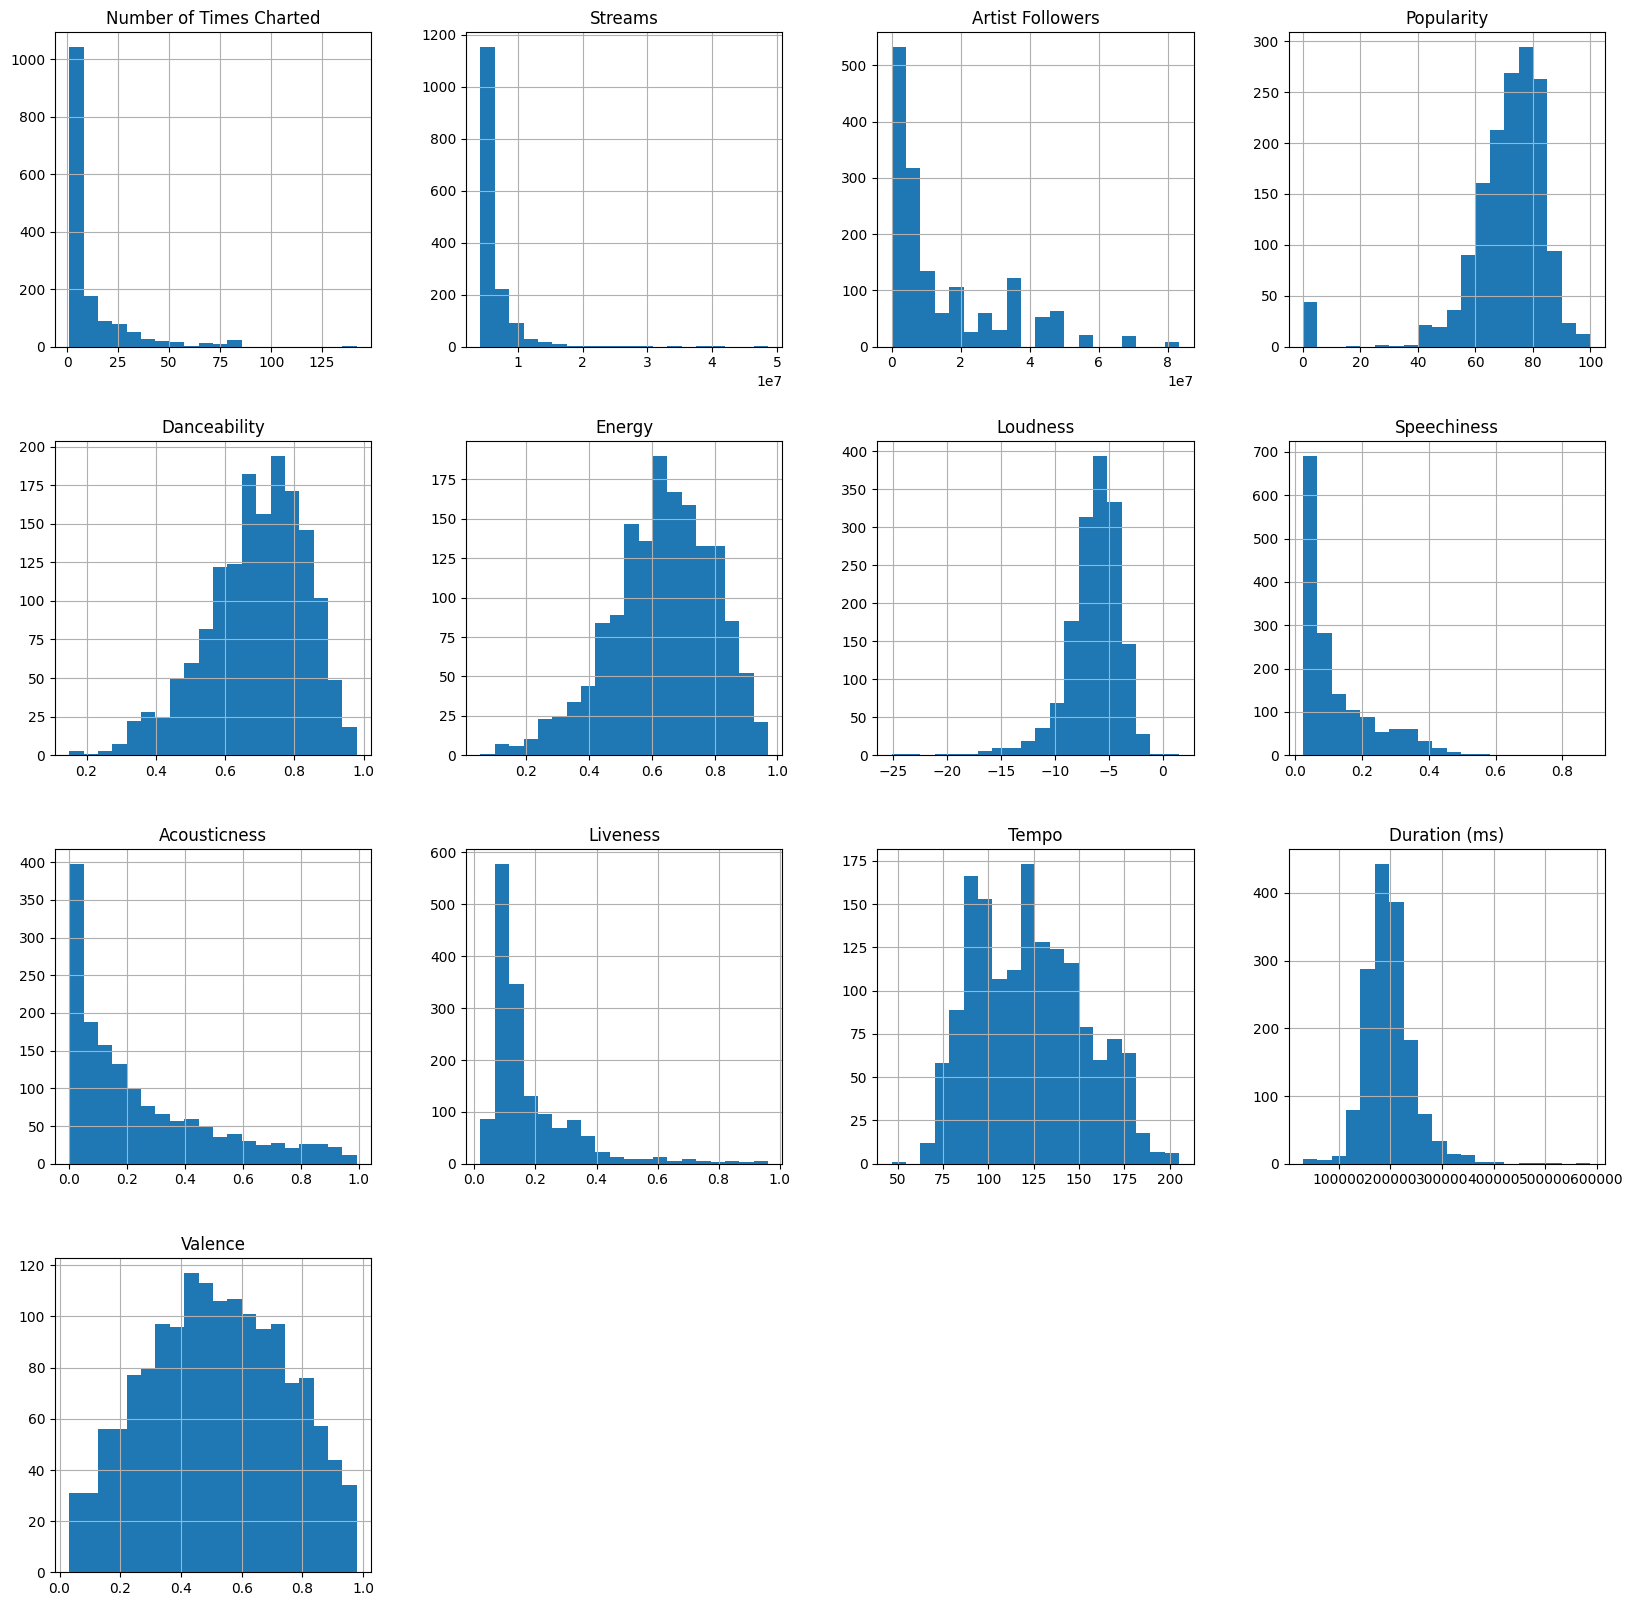

In [ ]:
# Histogram Grid shows distribution of the data across the data set variables.
spotify.hist(figsize=(20,20), bins=20)

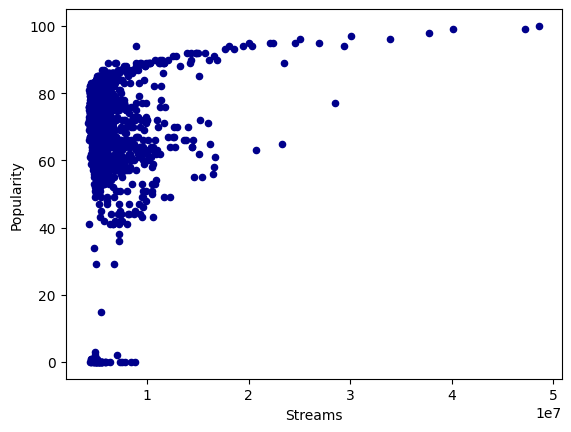

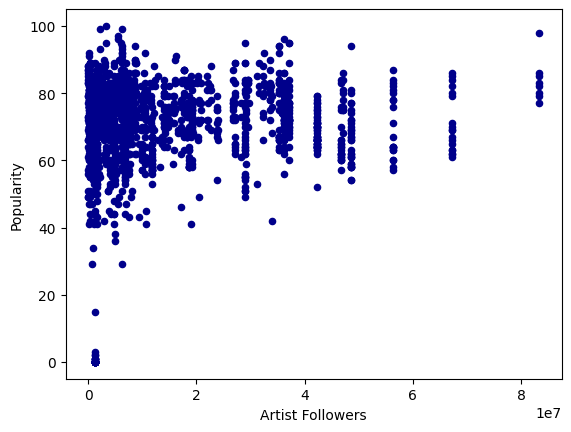

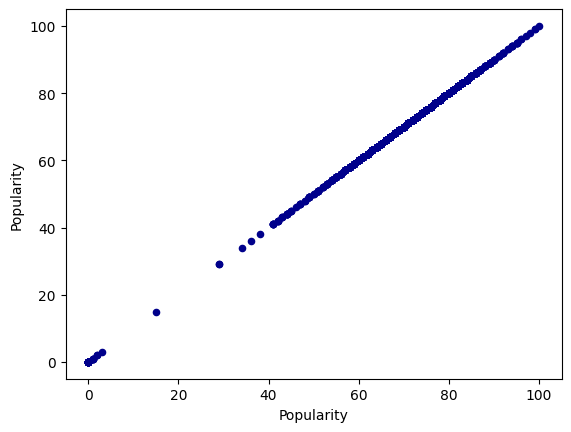

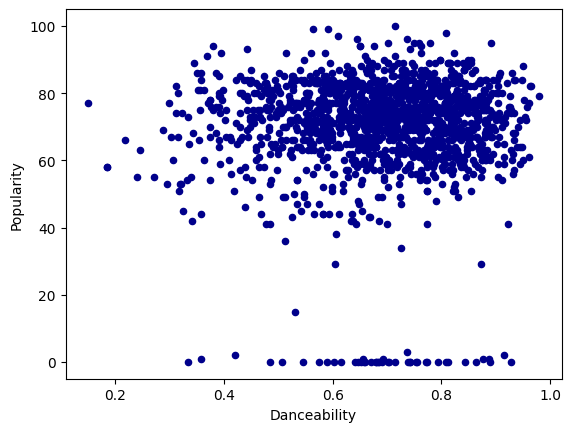

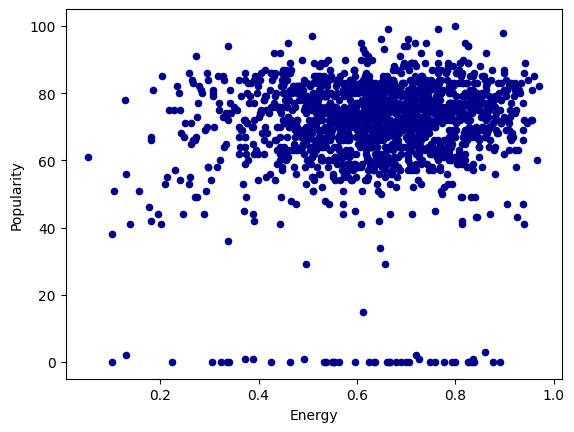

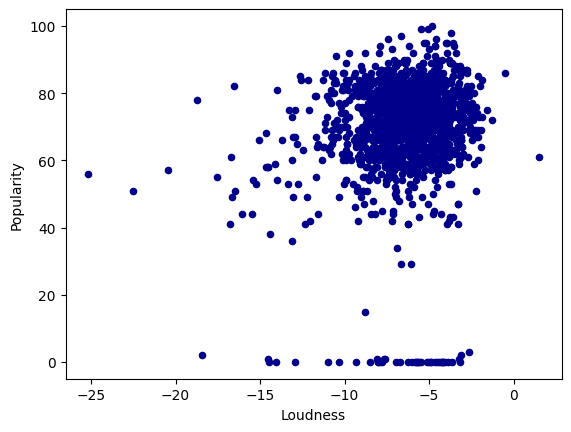

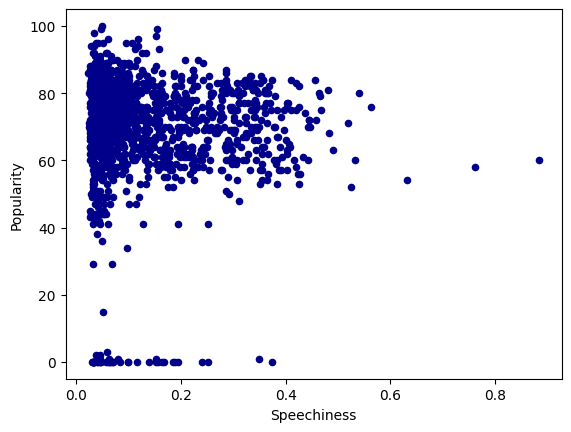

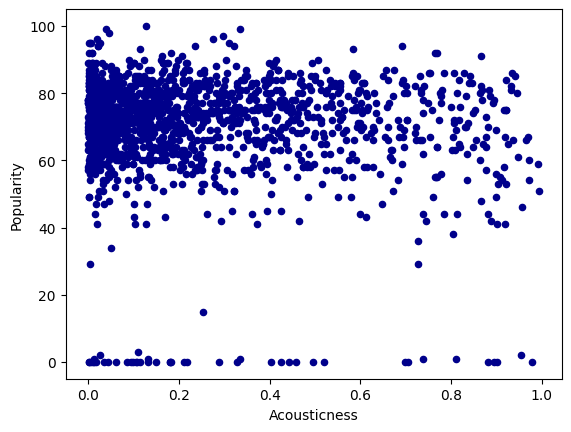

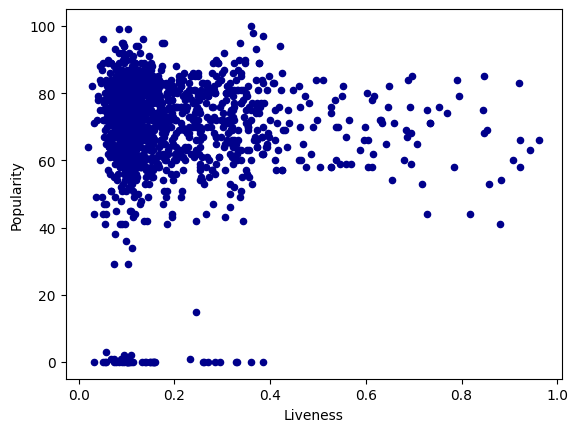

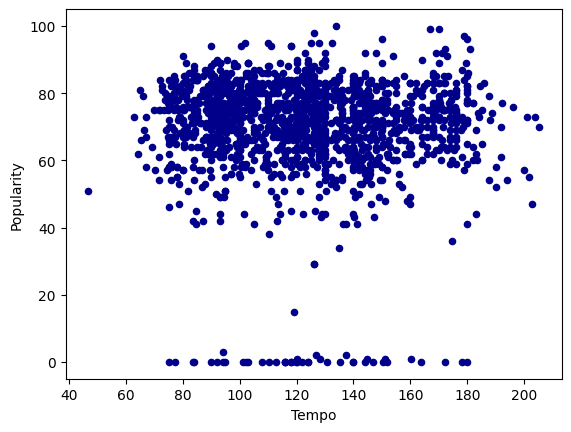

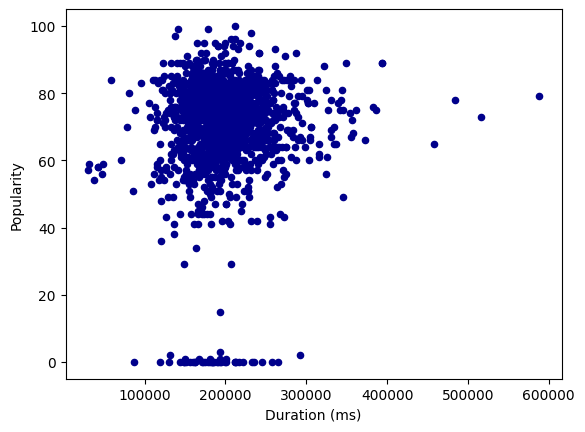

In [ ]:
# Filter values more than Absoulte value of 0.001
filter = np.abs(corr[target]) > .001
corr[filter]
selected_columns=corr[filter].index
selected_columns

# Plotting the Variables compared to the target prior to calcuations (the range excludes SalePrice)
for variable in selected_columns[1:14]:
  spotify.plot.scatter(x=variable,
                        y=target,
                        c='DarkBlue')
plt.show()

##Data Processing
>  "Crunch Numbers"

In [ ]:
y = spotify[target]
X = spotify[selected_columns].copy()
X.drop(target, axis=1, inplace=True)

In [ ]:
spotify[selected_columns].isna().sum()

,0
Number of Times Charted,0
Streams,0
Artist Followers,0
Popularity,0
Danceability,0
Energy,0
Loudness,0
Speechiness,0
Acousticness,0
Liveness,0


In [ ]:
X.columns

Index(['Number of Times Charted', 'Streams', 'Artist Followers',
       'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
       'Liveness', 'Tempo', 'Duration (ms)'],
      dtype='object')

In [ ]:
#Scale the data off of Sales, and split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

#Scaling, normalize the features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
np.isnan(X).sum()

,0
Number of Times Charted,0
Streams,0
Artist Followers,0
Danceability,0
Energy,0
Loudness,0
Speechiness,0
Acousticness,0
Liveness,0
Tempo,0


In [ ]:
# Fit a linear model using Sklearn
model = LinearRegression()
my_fit_lr = model.fit(X_train, y_train)

In [ ]:
# Create a data frame with the results from the linear regression models
model_results = pd.DataFrame()
model_results['Predictor'] = X.columns
model_results['Linear'] = my_fit_lr.coef_
model_results.sort_values(by=['Linear'],inplace=True, ascending=False)
model_results

,Predictor,Linear
0,Number of Times Charted,3.563658
5,Loudness,2.803871
1,Streams,2.087915
2,Artist Followers,1.298804
10,Duration (ms),0.736292
6,Speechiness,0.144797
3,Danceability,-0.275875
8,Liveness,-0.424492
4,Energy,-0.444640
9,Tempo,-0.708973


## Data Visualization
> "Lets Plot"

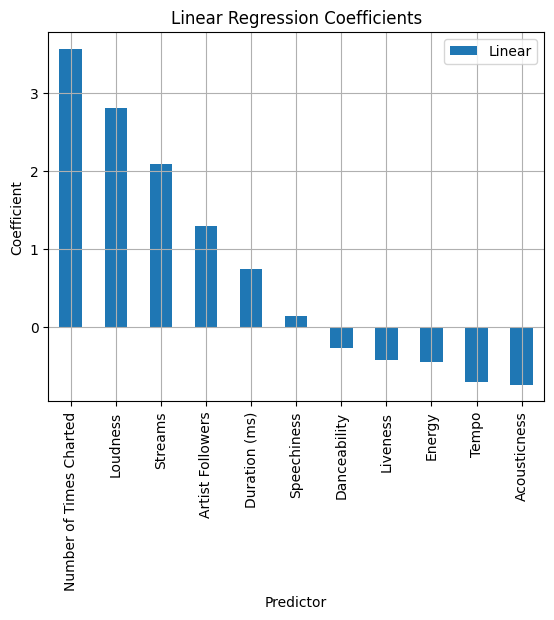

In [ ]:
# We can even plot the coefficients if we want to!
model_results.plot(x = 'Predictor', y = 'Linear', kind = 'bar', ylabel='Coefficient', title='Linear Regression Coefficients')
plt.grid()

In [ ]:
# Linear Regression
# Perform CV
n = 500
results = np.zeros(n)
for idx in range(n):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  results[idx] = np.sqrt(mean_squared_error(y_test,y_pred))
print(f"CV RMSE: {results.mean().round(2)}")
print(f"Number of Predictors: {len(X.columns)}")

CV RMSE: 15.1
Number of Predictors: 11


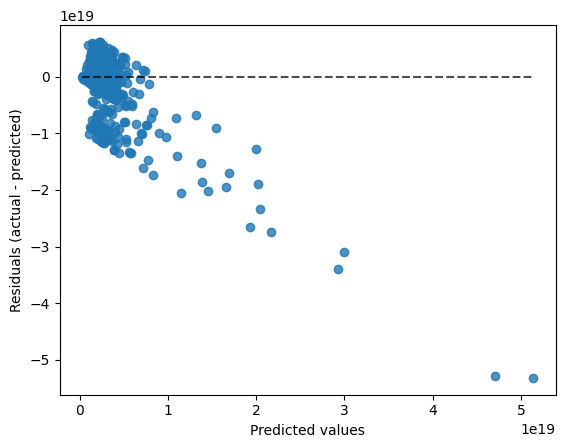

In [ ]:
display=sklearn.metrics.PredictionErrorDisplay(y_true=y_test**10, y_pred=y_pred**10)
display.plot()
plt.show()

In [ ]:
# Specify values of alpha we want to try
alph = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20, 30, 50]

# Create empty list to hold results
results_alpha = []

for i in alph:
  # Train the model
  my_fit_rr = Ridge(alpha = i) # Looping through alpha

  scalar = StandardScaler()

  pipeline = Pipeline([('transformer', scalar), ('estimator', my_fit_rr)])

  # Calculate CV RMSE
  results = cross_val_score(
      pipeline,
      X,
      y,
      scoring='neg_root_mean_squared_error',
      cv = 10
      )
  rmse = abs(results.mean())
  results_alpha.append(rmse)

results_df = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})
print(results_df.sort_values(by=['RMSE']))

           Alpha       RMSE
15  5.000000e+01  15.905560
14  3.000000e+01  15.916433
13  2.000000e+01  15.922107
12  1.000000e+01  15.927952
11  5.000000e+00  15.930942
10  4.000000e+00  15.931545
9   3.000000e+00  15.932151
8   2.000000e+00  15.932758
7   1.000000e+00  15.933367
6   1.000000e-01  15.933917
5   1.000000e-02  15.933972
4   1.000000e-03  15.933977
3   1.000000e-04  15.933978
2   1.000000e-08  15.933978
1   1.000000e-10  15.933978
0   1.000000e-15  15.933978


In [ ]:
#Trying Min - Max Scaler vs Standard Scaler
# Specify values of alpha we want to try
alph = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20, 30, 50]

# Create empty list to hold results
results_alpha = []

for i in alph:
  # Train the model
  my_fit_rr = Ridge(alpha = i) # Looping through alpha

  scalar = MinMaxScaler()

  pipeline = Pipeline([('transformer', scalar), ('estimator', my_fit_rr)])

  # Calculate CV RMSE
  results = cross_val_score(
      pipeline,
      X,
      y,
      scoring='neg_root_mean_squared_error',
      cv = 10
      )
  rmse = abs(results.mean())
  results_alpha.append(rmse)

results_df = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})
print(results_df.sort_values(by=['RMSE']))

           Alpha       RMSE
14  3.000000e+01  15.604172
13  2.000000e+01  15.606625
15  5.000000e+01  15.618818
12  1.000000e+01  15.645773
11  5.000000e+00  15.717368
10  4.000000e+00  15.742595
9   3.000000e+00  15.774098
8   2.000000e+00  15.814008
7   1.000000e+00  15.865551
6   1.000000e-01  15.926155
5   1.000000e-02  15.933184
4   1.000000e-03  15.933898
3   1.000000e-04  15.933970
2   1.000000e-08  15.933978
1   1.000000e-10  15.933978
0   1.000000e-15  15.933978


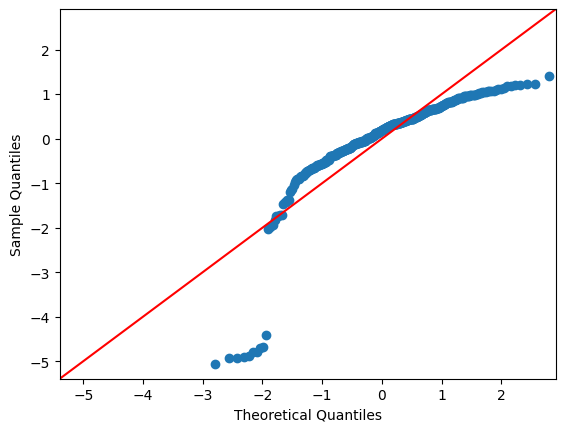

In [ ]:
# QQ Plot - Residuals are normally distributed
res = y_test - y_pred
sm.qqplot(res, fit=True, line="45") ;
# plt.xlim(-4, 4)
# plt.ylim(-4, 4)

In [ ]:
# %%capture --no-stdout
X_lasso = X
y_lasso = y

# Specify values of alpha we want to try
alph = [50, 75, 100, 200, 300, ]

# Create empty list to hold results
results_alpha = []

for i in alph:
  # Calculate CV RMSE
  n = 200
  results = np.zeros(n)

  for idx in range(n):
    # Create the model
    my_fit_lasso = Lasso(alpha = i, tol = .01, max_iter=10_000); # Looping through alpha

    # Train, test split
    X_train, X_test, y_train, y_test = train_test_split(X_lasso, y_lasso, test_size=0.25)

    # Standard scale only training features
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    # Scale testing features
    X_test = scaler.transform(X_test)

    # Fit regression
    my_fit_lasso.fit(X_train, y_train)

    # Predict
    y_predl = my_fit_lasso.predict(X_test)

    # Calculate and record performance metric
    results[idx] = np.sqrt(mean_squared_error(y_test,y_predl))

  results_alpha.append(results.mean())

results_df = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})


In [ ]:
my_fit_lasso.coef_

array([ 0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.])

In [ ]:
results_df

,Alpha,RMSE
0,50,15.879171
1,75,15.869740
2,100,15.854312
3,200,15.730947
4,300,15.739325


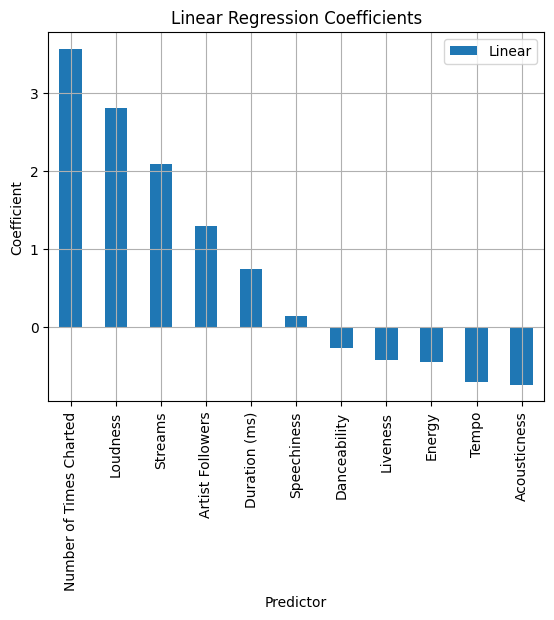

In [ ]:
# We can even plot the coefficients if we want to!
model_results.plot(x = 'Predictor', y = 'Linear', kind = 'bar', ylabel='Coefficient', title='Linear Regression Coefficients')
plt.grid()

In [ ]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=3)         # Arbitrarily choosing max_depth of 3
  model.fit(X_train,y_train)
  y_predt = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_predt))

print(f"CV RMSE: {rms_error.mean().round(2)}")

CV RMSE: 10.58


(-4.0, 4.0)

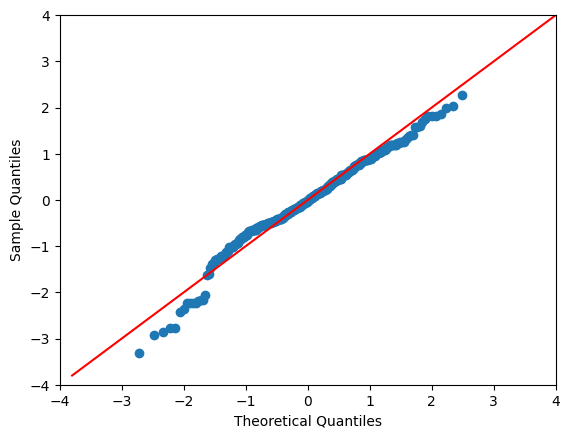

In [ ]:
# QQ Plot of Decision Tree - Residuals are normally distributed
res = y_test - y_predt
sm.qqplot(res, fit=True, line="45") ;
plt.xlim(-4, 4)
plt.ylim(-4, 4)

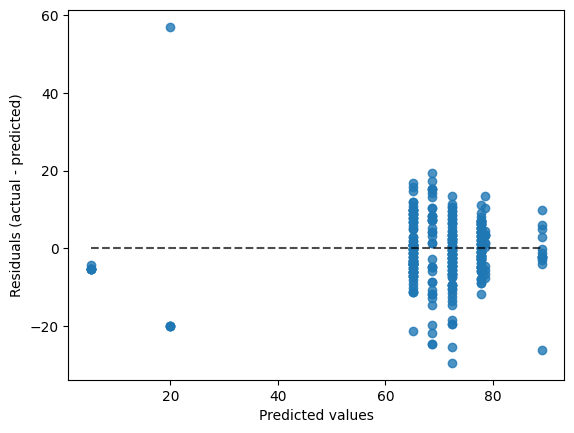

In [ ]:
display=sklearn.metrics.PredictionErrorDisplay(y_true=y_test, y_pred=y_predt)
display.plot()
plt.show()

In [ ]:
np.unique(y)

array([  0,   1,   2,   3,  15,  29,  34,  36,  38,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100])

## Communication of Results
> "What did we find?"

Using **'Popularity'** as target, the features were limited based on correlation to target:

* Number of Times Charted
*	Loudness
*	Streams
*	Artist Followers
* Duration (ms)
*	Speechiness
*	Danceability
*	Liveness
*	Energy
*	Tempo
*	Acousticness

Linear Regression provided CV RMSE: 14.98

Ridge Regression provided RMSE: 15.60

Lasso Regression RMSE: 15.69

Decision Tree CV RMSE: 10.7

Although the RMSE was improved, the results from QQ plot showed curve pattern and heavy tails.  This could possibly be from skewed data results and extreme values.